### Por realizar:

* Limpiar data
* Verificar sintomas y outcome.
* Cuanta gente existe por grupo etario
* Mostrar sintomás que más se repite
* Ver modelo de regresión linear simple para aplicar acá


## Análisis de datos COVID-19

### Objetivo:
#### Identificación de individuos que presentan síntomas y características específicas, padecen la enfermedad COVID-19 y están con riesgo de muerte.

#### Se utilizarán herramientas de análisis de datos con Python, Pandas, Matplotlib, numpy y scikit-learn.

In [49]:
# Importamos las librerías necesarias para el análisis de datos.
# Pandas para el manejo y tratamiento de los datos
# Numpy para poder trabajar con matrices multidimensionales
# Matplotlib para visualización de data
# Seaborn para visualización de data, basado en matplotlib
# Re para expresiones regulares

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

# Se indica a matplotlib mostrar el gráfico en la celda a ejecutar y guarda el gráfico en el notebook.
%matplotlib inline
# Configura los estilos de los gráficos de seaborn
sns.set_style("whitegrid")

# Otros
import glob, os


### 0) Preparación de la información y data
#### Importaremos el dataset 

In [50]:
# Importamos el archivo CSV como un DF
df_full = pd.read_csv('latestdata.csv')


/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,2,9,10,12,13,14,15,16,17,19,21,22,23,24,25,26,27,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [51]:
# Creamos un nuevo DF con las filas donde las edades no son nulos
df_preProcessing = df_full[df_full['age'].notna()]


In [52]:
# Creamos un nuevo DF solo con las columnas que nos sirven y fueron previamente limpiadas por edad.
df_clean = df_preProcessing[[
     'age', 'sex', 'date_onset_symptoms', 
     'date_admission_hospital', 'date_confirmation', 
     'symptoms', 'chronic_disease_binary', 'chronic_disease', 
     'source', 'outcome', 'date_death_or_discharge', 'notes_for_discussion', 'country'
     ]]

df_clean.head()


,age,sex,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,chronic_disease_binary,chronic_disease,source,outcome,date_death_or_discharge,notes_for_discussion,country
1,78,male,NaN,NaN,21.02.2020,NaN,False,NaN,https://www.corriere.it/cronache/20_febbraio_2...,death,22.02.2020,NaN,Italy
2,61,female,NaN,NaN,14.02.2020,NaN,False,NaN,https://www.channelnewsasia.com/news/singapore...,discharge,17.02.2020,NaN,Singapore
27,66,male,NaN,NaN,07.02.2020,NaN,False,NaN,https://m.weibo.cn/detail/4469604653292027,NaN,NaN,https://www.google.com/maps/place/Zhenlai+Coun...,China
28,27,female,NaN,NaN,07.02.2020,NaN,False,NaN,https://m.weibo.cn/detail/4469604653292027,NaN,NaN,NaN,China
29,17,male,NaN,NaN,07.02.2020,NaN,False,NaN,https://m.weibo.cn/detail/4469604653292027,NaN,NaN,NaN,China


In [53]:
# Analizamos las filas con datos nulos que quedan en el dataset, en la edad no quedan nulos
obj = df_clean.isnull().sum()
for key, value in obj.iteritems():
    print(key, ",", value)

age , 0
sex , 1756
date_onset_symptoms , 78534
date_admission_hospital , 240989
date_confirmation , 218
symptoms , 241499
chronic_disease_binary , 0
chronic_disease , 242915
source , 154102
outcome , 240552
date_death_or_discharge , 242588
notes_for_discussion , 242827
country , 44


### 1) Análisis, limpieza y agrupación de datos por Edad


In [54]:
# Cuenta total de registros por edad
ageTotalCount = df_clean.age.count()
print("Existen {} registros de edad".format(ageTotalCount))


Existen 243077 registros de edad


In [55]:
# Visualización de formatos de edad
# df_clean.age.unique()
print("ver edad")

ver edad


In [56]:
# Visualización del DF sin nulos en la edad
df_clean.head()


,age,sex,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,chronic_disease_binary,chronic_disease,source,outcome,date_death_or_discharge,notes_for_discussion,country
1,78,male,NaN,NaN,21.02.2020,NaN,False,NaN,https://www.corriere.it/cronache/20_febbraio_2...,death,22.02.2020,NaN,Italy
2,61,female,NaN,NaN,14.02.2020,NaN,False,NaN,https://www.channelnewsasia.com/news/singapore...,discharge,17.02.2020,NaN,Singapore
27,66,male,NaN,NaN,07.02.2020,NaN,False,NaN,https://m.weibo.cn/detail/4469604653292027,NaN,NaN,https://www.google.com/maps/place/Zhenlai+Coun...,China
28,27,female,NaN,NaN,07.02.2020,NaN,False,NaN,https://m.weibo.cn/detail/4469604653292027,NaN,NaN,NaN,China
29,17,male,NaN,NaN,07.02.2020,NaN,False,NaN,https://m.weibo.cn/detail/4469604653292027,NaN,NaN,NaN,China


In [57]:
# Copia del DF sin nulos para modificarlo y poder trabajar las edades
df_test = df_clean

df_test.count()

age                        243077
sex                        241321
date_onset_symptoms        164543
date_admission_hospital      2088
date_confirmation          242859
symptoms                     1578
chronic_disease_binary     243077
chronic_disease               162
source                      88975
outcome                      2525
date_death_or_discharge       489
notes_for_discussion          250
country                    243033
dtype: int64

### Implementar Regex para estandarizar la data
#### Usar RegEX para validar los siguientes casos:

* Numeros enteros, guardar como enteros         ^\d(\d?)+$
* Rango de edades, obtener la media y guardar   ^\d(\d+)?\s?[-]\s?\d(\d+)?$
* Numeros decimales, redondear y guardar        ^\d(\.\d+)?$
* Edades con signo + / -                        ^\d\d?[-]?[+]?$
* Numeros y letras, obtener número y guardar    ^\d\d?\s\w+?$

RegEx devuelve un arreglo con el valor que haga match con la expresión

In [68]:
# Declaración de expresiones regulares
ageInt = '^\d(\d?)+$'
ageRange = '^\d(\d+)?\s?[-]\s?\d(\d+)?$'
ageFloat = '^\d(\.\d+)?$'
ageSign = '^\d\d?[-]?[+]?$'
ageText = '^\d\d?\s\w+?$'

# Arreglo para guardar nueva lista de edades
new_ages = []

# Recorremos las edades para estandarizar la información
for ages in df_test.age:
    strAges = str(ages)
    # RegEx Numeros enteros
    if re.findall(ageInt, strAges):
        new_ages.append(ages)
    # RegEx Rango de numeros
    elif re.findall(ageRange, strAges):
        indexes = ages.split('-')
        intIndexes = list(map(int, indexes))
        medianIndex = np.median(intIndexes)
        new_ages.append(int(medianIndex))
    # RegEx Numeros flotantes
    elif re.findall(ageFloat, strAges):
        formattedAge = int(round(float(ages)))
        new_ages.append(formattedAge)
    # ReEx Edades con signos (+/-)
    elif re.findall(ageSign, strAges):
        ageSt = re.findall(r'\d+', ages)
        new_ages.append(int(ageSt[0]))
    # Regex Edades con texto
    elif re.findall(ageText, strAges):
        monthAge = ages.split()
        monthConversion = int(monthAge[0]) / 12
        ageConverted = int(round(monthConversion))
        new_ages.append(ageConverted)
    else:
        new_ages.append("ERROR")
        
    
# Agregamos una nueva columna al DF con la edades nuevas
df_test["new_age"] = new_ages

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [59]:
# Reemplaza los datos nulos en la columna "Country" por el dato "Other" para poder separarlos
df_test['country'].fillna("Other", inplace=True)
df_test.isin(['Other']).any()

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


age                        False
sex                        False
date_onset_symptoms        False
date_admission_hospital    False
date_confirmation          False
symptoms                   False
chronic_disease_binary     False
chronic_disease            False
source                     False
outcome                    False
date_death_or_discharge    False
notes_for_discussion       False
country                     True
new_age                    False
dtype: bool

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


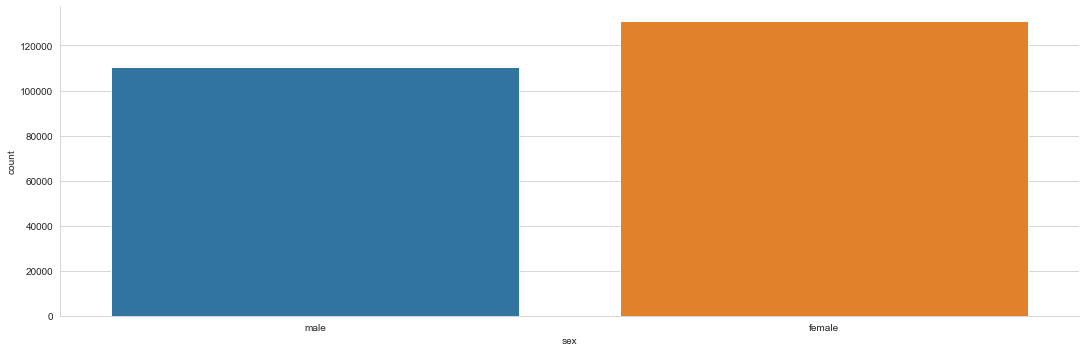

In [60]:
# Muestra la cantidad de contagios en hombres y mujeres
sns.factorplot('sex',data=df_test,kind="count", aspect=3)

### Agrupación de edades
#### Se crearán grupos de edad con la cantidad de registros coincidentes, estos serán:

* Niño: 0 - 8 años
* Adolescente: 9 - 14 años
* Joven: 15 - 18 años
* Adulto: 19 - 40 años
* Adulto Medio: 41 - 60 años
* Adulto Mayor: 60-120 años


In [61]:
# Creamos segmentación de grupos etarios con sus respectivas edades
gruposEtarios = [
    {'Niño': [0, 8]},
    {'Adolescente': [9, 14]},
    {'Joven': [15, 18]},
    {'Adulto': [19, 40]},
    {'Adulto Medio': [41, 60]},
    {'Adulto Mayor': [60, 120]}
]

# Inicializamos diccionario que tendrá el valor total de la cantidad por grupo
cantidadGrupoEtario = {
    'Niño': 0 ,
    'Adolescente': 0 ,
    'Joven': 0 ,
    'Adulto': 0 ,
    'Adulto Medio': 0 ,
    'Adulto Mayor': 0 
}

In [69]:
# Recorremos datos para clasificar grupos y guardarlo en un nuevo diccionario
df_edades = df_test.new_age

for getAge in df_edades:
    # Convertimos la edad a int
    if getAge != 'ERROR':
        currentAge = int(getAge)
        for ageRange in gruposEtarios:
            # Obtenemos el nombre del grupo etario y el rango (valores)
            ageRangeName = list(ageRange)[0]
            ageRangeValue = list(ageRange.values())[0]
            # Verificamos que la edad calce en un grupo etario para sumarla al total
            if ageRangeValue[0] <= currentAge <= ageRangeValue[1]:
                # Obtenemos la cantidad actual del rango en el diccionario
                dictActualValue = cantidadGrupoEtario.get(ageRangeName)
                # Actualizar el objeto final con cada dato
                cantidadGrupoEtario.update({ageRangeName: dictActualValue + 1})

# Mostramos valor del diccionario actualizado   
print(cantidadGrupoEtario)

{'Niño': 2257, 'Adolescente': 4476, 'Joven': 512, 'Adulto': 59068, 'Adulto Medio': 92366, 'Adulto Mayor': 84747}


In [67]:
# Export DF to excel
# df_test.to_excel("reAged3.xlsx") 
